# Package + Data ETL

In [0]:
# load data from drive
# package loading

import numpy as np 
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

%matplotlib inline

pal = sns.color_palette()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# set drive path

path = "/content/drive/My Drive/NLP/Data/train.csv"
df = pd.read_csv(path)

In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,word_share,q1len,q2len,q1_n_words,q2_n_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.434783,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.200000,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.166667,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.100000,76,39,13,7


In [0]:
print('Total number of question pairs: {}'.format(len(df)))
print('Total Duplicate pairs: {}%'.format(round(df['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Total number of questions: {}'.format(len(np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

Total number of question pairs: 404290
Total Duplicate pairs: 36.92%
Total number of questions: 537933
Number of questions that appear multiple times: 111780


# EDAV

In [0]:
# initial description

df.shape

(404290, 6)

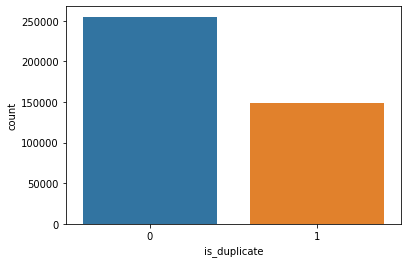

In [0]:
sns.countplot(df['is_duplicate'])

The label is relatively balanced. For this task, I will not resample the data. 

I assume the dataset is constructed by questions with some shared tags.

But when applied to real life, depending on situations, I will resample the data to follow the real distribution of the test as close as possible.

Text(0, 0.5, '# of questions')

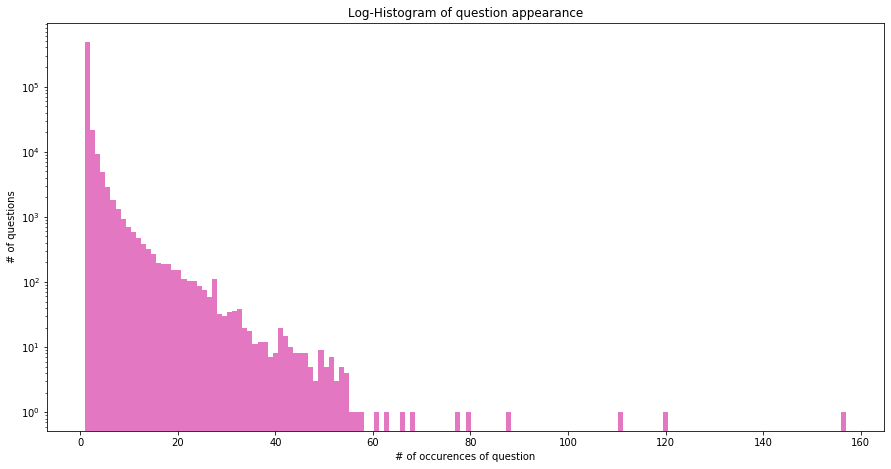

In [0]:
# check question occurence

plt.figure(figsize=(15, 7.5))
plt.hist(qids.value_counts(), bins=150, color=pal[6])
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance')
plt.xlabel('# of occurences of question')
plt.ylabel('# of questions')

Most questions appear only a few times, while some questions appear a lot of times, and one outlier appeares around 160 times. This distribution obeys the power law。

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
No handles with labels found to put in legend.


Text(0, 0.5, 'Probability')

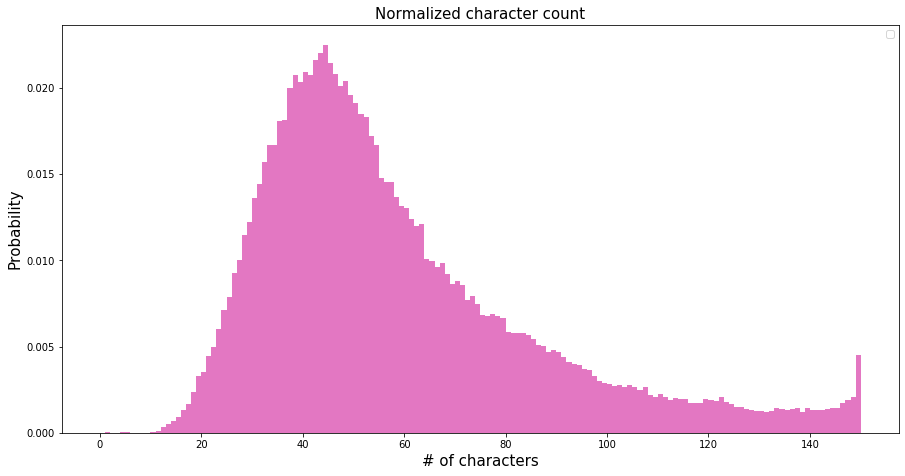

In [0]:
questions = pd.Series(df['question1'].tolist() + df['question2'].tolist()).astype(str)
dist = questions.apply(len)

plt.figure(figsize=(15, 7.5))
plt.hist(dist, bins=150, range=[0, 150], color=pal[6], normed=True)
plt.title('Normalized character count', fontsize=15)
plt.legend()
plt.xlabel('# of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

Most questions have anywhere from 15 to 150 characters in them.

There is a steep cut-off at 150 characters. At that time, the limit for questions on Quora is 150 characters. It follows the power law as well.

In [0]:
# do the same work for words
# word_tokenize would take some time

import nltk
from nltk import word_tokenize 
nltk.download('punkt')

dist_2 = questions.apply(lambda x: len(word_tokenize(x)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
No handles with labels found to put in legend.


Text(0, 0.5, 'Probability')

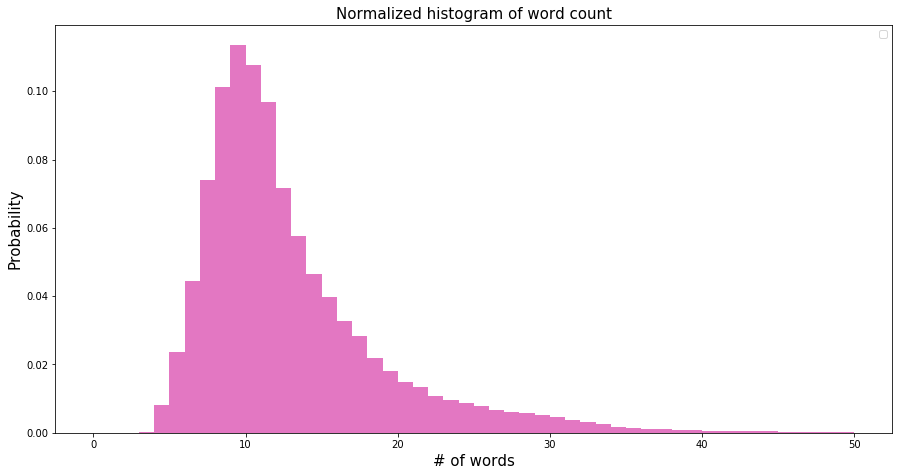

In [0]:
plt.figure(figsize=(15, 7.5))
plt.hist(dist_2, bins=50, range=[0, 50], color=pal[6], normed=True)
plt.title('Normalized histogram of word count', fontsize=15)
plt.legend()
plt.xlabel('# of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

There is a similar distribution for words. 

Most questions are about 10 words long.

Let's take a look at the most common words by wordcloud.

(-0.5, 1439.5, 1079.5, -0.5)

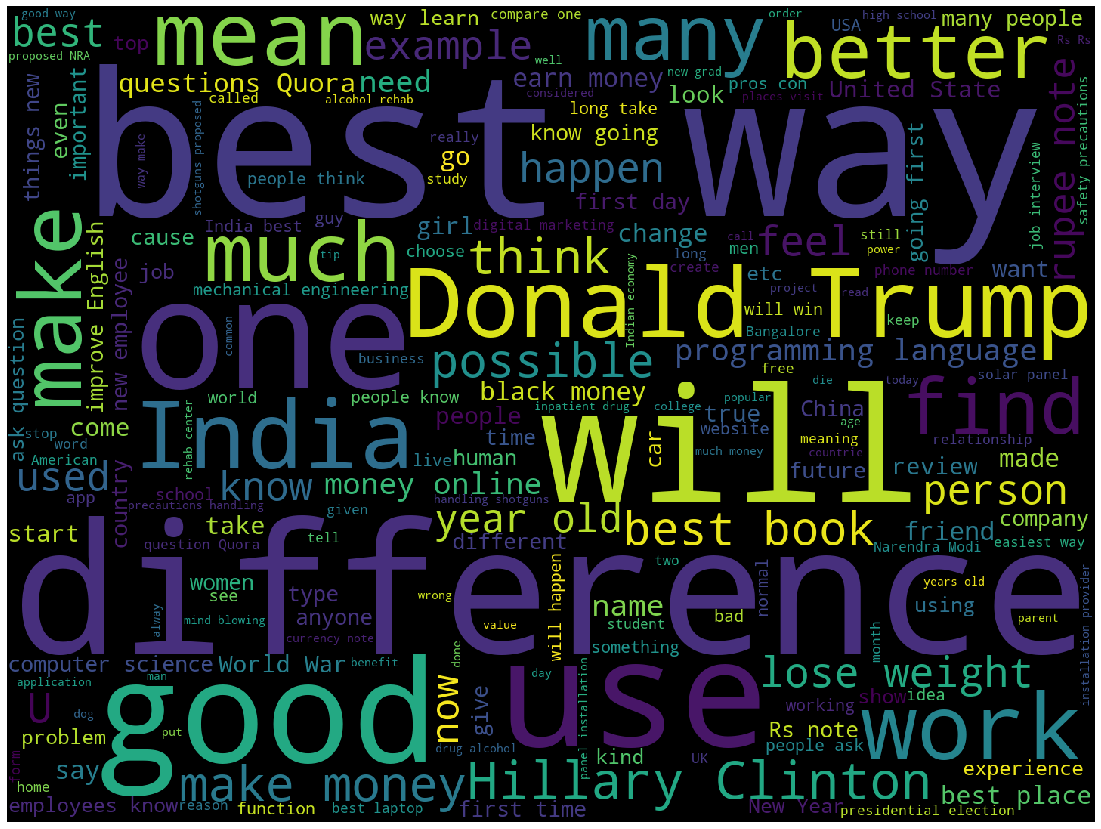

In [0]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

well... not much helpful but goodlooking visual

In [0]:
# Basic Semantic Analysis

qmarks = np.mean(questions.apply(lambda x: '?' in x))
fullstop = np.mean(questions.apply(lambda x: '.' in x))
capital_first = np.mean(questions.apply(lambda x: x[0].isupper()))
numbers = np.mean(questions.apply(lambda x: max([y.isdigit() for y in x])))

print('With question marks: {:.2f}%'.format(qmarks * 100))
print('With \'.\' stops in the middle: {:.2f}%'.format(fullstop * 100))
print('With capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('With numbers: {:.2f}%'.format(numbers * 100))

With question marks: 99.87%
With '.' stops in the middle: 6.31%
With capitalised first letters: 99.81%
With numbers: 11.83%


# check the words share situation

In [0]:
# how many words are shared by two questions
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
            
    # in case there are some fake questions
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


Text(0.5, 0, 'word_match_share')

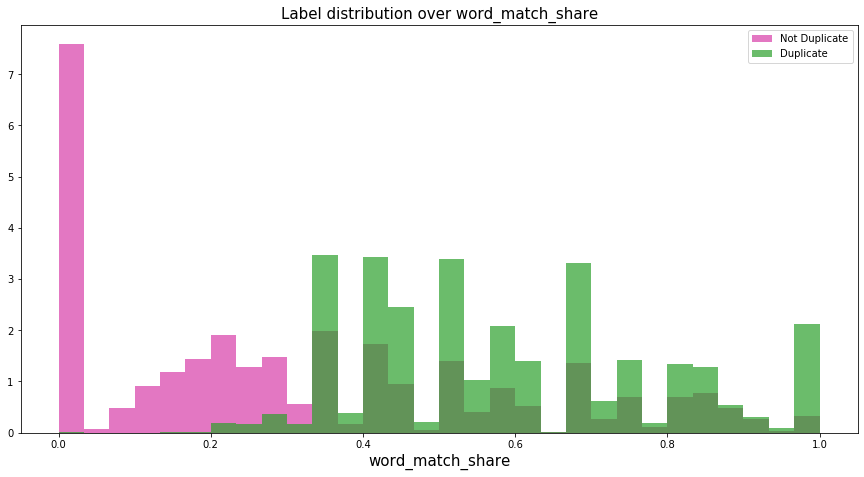

In [0]:
plt.figure(figsize=(15, 7.5))
train_word_match = df.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df['is_duplicate'] == 0], bins=30, normed=True, label='Not Duplicate', color=pal[6])
plt.hist(train_word_match[df['is_duplicate'] == 1], bins=30, normed=True, alpha=0.7, label='Duplicate', color=pal[2])
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

We can see this feature can be kinda helfpul, as it separates the duplicate and non-duplicate questions quite well, especially for detecting non-duplicate questions.

In [0]:
# add word share feature

df = df.fillna("")
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))


df['word_share'] = df.apply(normalized_word_share, axis=1)

Text(0.5, 1.0, 'Violin plot for is_duplicate and word_share')

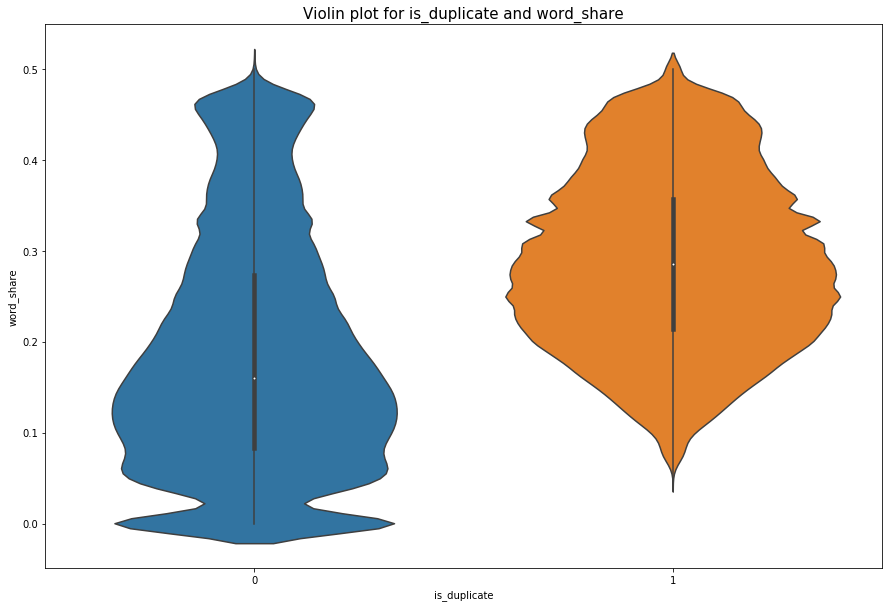

In [0]:
# violin plot showing relation between word share and label

plt.figure(figsize=(15, 10))
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df)
plt.title('Violin plot for is_duplicate and word_share', fontsize=15)

# T-SNE 3D representation

I engineered some features such as question length; shared words and did an exploratory analysis with t-sne. We can see it did a great job in separating a lot of non-duplicate questions. However, in 1 dimension, duplicate and non-duplicate pairs intervened with each other. And I believe that is the part that makes this problem hard. 

In [0]:
!pip show plotly

Name: plotly
Version: 4.1.1
Summary: An open-source, interactive graphing library for Python
Home-page: https://plot.ly/python/
Author: Chris P
Author-email: chris@plot.ly
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, retrying
Required-by: cufflinks, chart-studio


In [0]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [0]:
# new feature creation

df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

In [0]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

df_subsampled = df.sample(n=5000)

X = MinMaxScaler().fit_transform(df_subsampled[['q1_n_words', 'q1len', 'q2_n_words', 'q2len', 'word_share']])
y = df_subsampled['is_duplicate'].values

tsne = TSNE(
    n_components=3,
    init='random', 
    method='barnes_hut',
    n_iter=300,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.129s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.024815
[t-SNE] Computed conditional probabilities in 0.291s
[t-SNE] Iteration 50: error = 83.3900070, gradient norm = 0.0314629 (50 iterations in 9.848s)
[t-SNE] Iteration 100: error = 70.7724762, gradient norm = 0.0031698 (50 iterations in 6.506s)
[t-SNE] Iteration 150: error = 69.1711426, gradient norm = 0.0016227 (50 iterations in 6.138s)
[t-SNE] Iteration 200: error = 68.6218033, gradient norm = 0.0010700 (50 iterations in 6.028s)
[t-SNE] Iteration 250: error = 68.3470154, gradient norm = 0.0009267

In [0]:
# Notice: If running on colab; have to excute this block twice... 
# I don't know the reasons behind, but works fine on my local PC

trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig)

From the EDAV, my main conclusion is this problem is maybe beyond the scope of traditional statistical learning. To find more complicated representations of the data, it can be a good idea to introduce some deep learning structures.

# Benchmark Model - XGBoost

train, valid, test = 0.8, 0.1, 0.1

evaluation -> accuracy

In [0]:
from collections import Counter

# If a word appears only once, we ignore it
# Epsilon makes the effect of extremely rare words smaller

def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(questions)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [0]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

In [0]:
x = pd.DataFrame()

word_match = df.apply(word_match_share, axis=1, raw=True)
tfidf_word_match = df.apply(tfidf_word_match_share, axis=1, raw=True)

x['word_match'] = word_match
x['tfidf_word_match'] = tfidf_word_match
x['q1len'] = df['q1len']
x['q2len'] = df['q2len']
x['q1_n_words'] = df['q1_n_words']
x['q2_n_words'] = df['q2_n_words']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

invalid value encountered in double_scalars



In [0]:
y = df['is_duplicate']

In [0]:
# train, validation, test split

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size= .2, random_state= 1234)
# x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size= .5, random_state= 1234)

Now it's time to introduce our old friend - XGBoost to set up a benchmark accuracy for this study.

In [0]:
# take a look at my cleaned training set

x_train.head()

,word_match,tfidf_word_match,q1len,q2len,q1_n_words,q2_n_words
399613,0.500000,0.493545,41,46,7,9
159754,0.800000,0.799257,23,39,4,6
292844,0.444444,0.433485,46,114,9,21
209008,0.363636,0.380526,57,59,11,14
404209,0.727273,0.683345,48,56,10,11


In [0]:
import xgboost as xgb

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'error'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=10)
# I felt like I pushed myself a little bit to hard for this benchmark score...

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-error:0.273031	valid-error:0.270771
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 50 rounds.
[10]	train-error:0.273099	valid-error:0.270548
[20]	train-error:0.271139	valid-error:0.269287
[30]	train-error:0.269791	valid-error:0.267926
[40]	train-error:0.26967	valid-error:0.267828
[50]	train-error:0.2692	valid-error:0.267259
[60]	train-error:0.268842	valid-error:0.267259
[70]	train-error:0.268647	valid-error:0.266912
[80]	train-error:0.268619	valid-error:0.266987
[90]	train-error:0.266195	valid-error:0.265057
[100]	train-error:0.264201	valid-error:0.263301
[110]	train-error:0.264133	valid-error:0.263252
[120]	train-error:0.263728	valid-error:0.263054
[130]	train-error:0.263354	valid-error:0.262683
[140]	train-error:0.263181	valid-error:0.262905
[150]	train-error:0.263171	valid-error:0.262881
[160]	train-error:0.263109	valid-error:0.262831
[170]	train-error:0.263116	valid-error:0.262806
[18

Okay, it seems that if my final model's is better than 0.75, we can beat the benchmark.

I wish I can also compete with the 0.83 academia milestone.





## Reasons on why I choose accuracy:


1.   Quora's Kaggle Competition used log-loss, which is just a more naunced view of accuracy.
2.   According to those top released models, they treat accuracy as their golden metrics. A better accuracy score, for this problem, does lead to better (or at least equal) precision and recall.
3. It's definitely worth observing other metrics. But for this study, main focus is put on improving model structure and parameter tuning, so one gold metric should be fine.

